In [1]:
%run ../nn_option_pricer/_key_imports.py

import sys

sys.path.append("../")
from nn_option_pricer.nn_archi import *
from nn_option_pricer.bachelier import *
from nn_option_pricer.utils import plot_loss

In [3]:
X_df_train = pd.read_csv("datasets/bachelier_train.csv")

N_ASSETS = len([x for x in X_df_train.columns if x.find("asset_") == 0])


Xs_train = X_df_train.iloc[:, :N_ASSETS].values.astype(np.float32)
ys_train = X_df_train["call_payoff"].values.astype(np.float32)
grads_train = X_df_train.iloc[:, N_ASSETS : (2 * N_ASSETS)].values.astype(np.float32)

X_df_test = pd.read_csv("datasets/bachelier_train.csv")
Xs_test = X_df_test.iloc[:, :N_ASSETS].values.astype(np.float32)
ys_test = X_df_test["call_payoff"].values.astype(np.float32)
grads_test = X_df_test.iloc[:, N_ASSETS : (2 * N_ASSETS)].values.astype(np.float32)


X_tensor = tf.Variable(Xs_test)

all_model_preds = {}
all_model_grads = {}
all_model_hessian = {}
all_models = {}

intrinsic_val = (
    X_df_test["call_payoff"] > np.maximum(X_df_test["basket"] - 1.0, 0)
) * 1
all_res = []

In [4]:
"""
Neural Network Hyperparameters
"""
HIDDEN_UNITS = 512
LAYERS = 1
dropout_ratio = 0.0
HIDDEN_ACT = "softplus"
N_FEATS = N_ASSETS
OUTPUT_ACT = None
DROPOUT_RATIO = 0.0
LR = 1e-2
BATCH_SIZE = 32
EPOCHS = 30
BATCH_NORM = False

loss_fn = tf.keras.losses.MeanSquaredError()
METRICS = [
    tf.keras.metrics.MeanAbsoluteError(name="MAE"),
    tf.keras.metrics.RootMeanSquaredError(name="RMSE"),
]
VAL_SPLIT = 0.2

CALLBACKS = [
    EarlyStopping(patience=10, restore_best_weights=True),
    TQDMProgressBar(show_epoch_progress=False),
    ReduceLROnPlateau(patience=5),
]

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

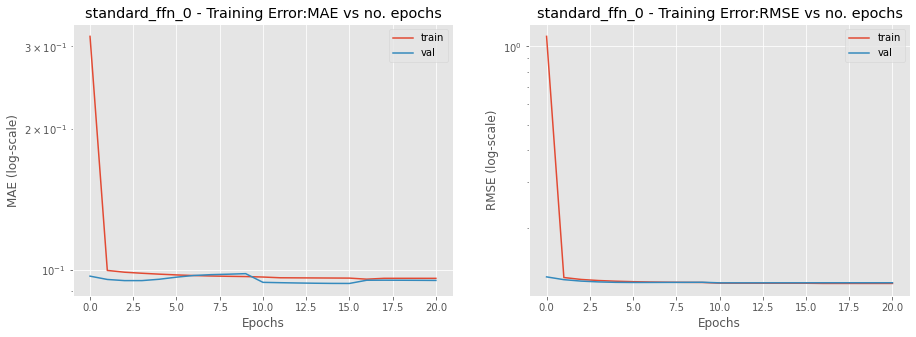

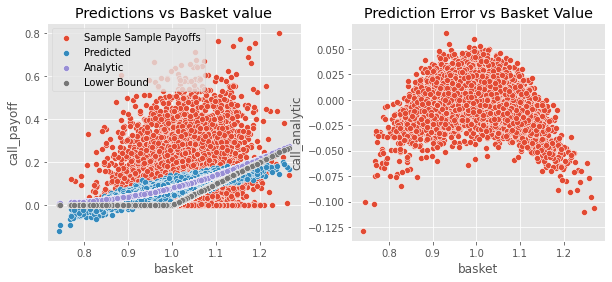

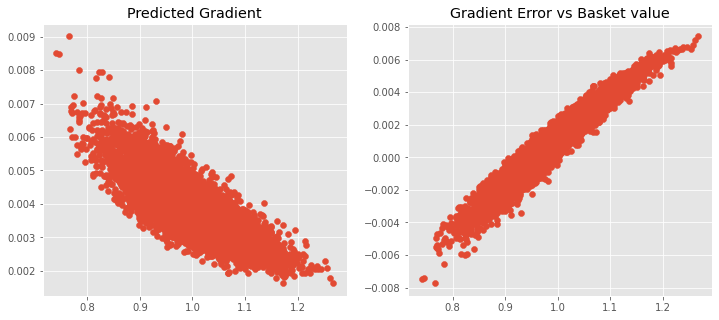

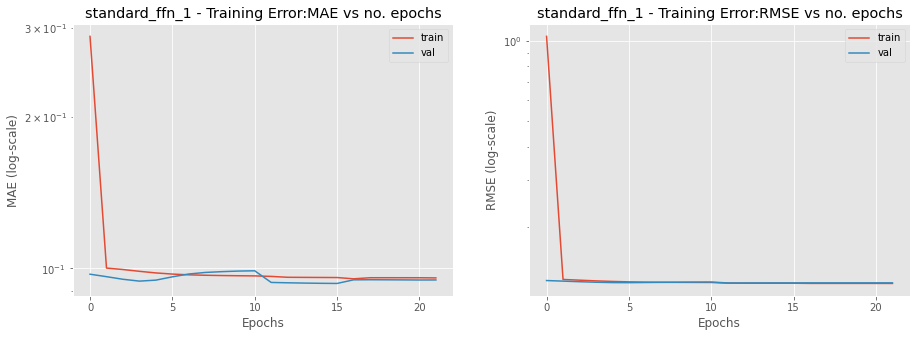

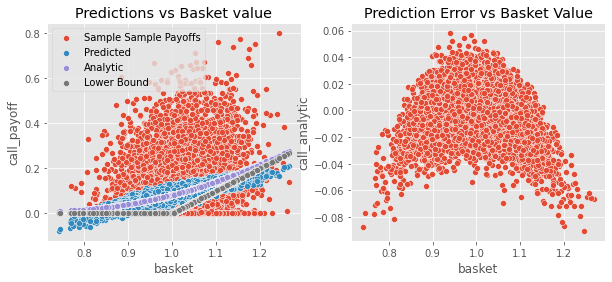

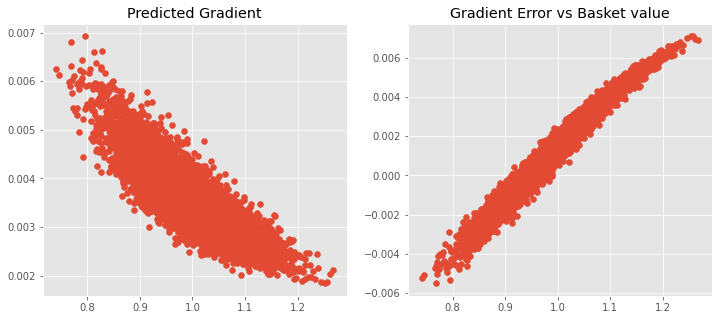

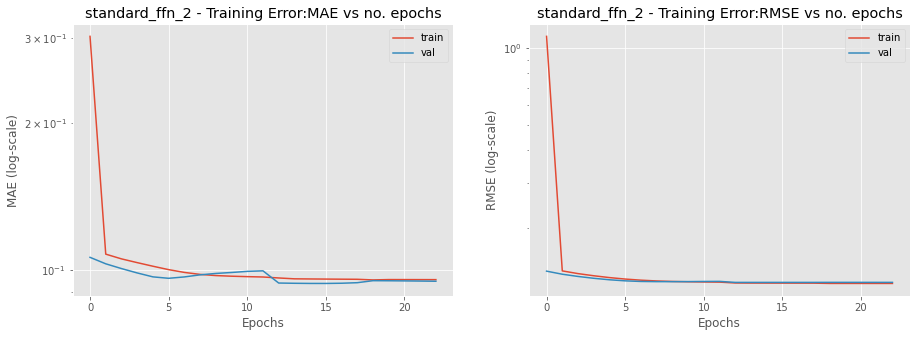

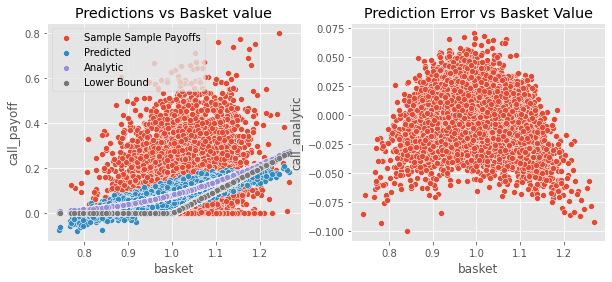

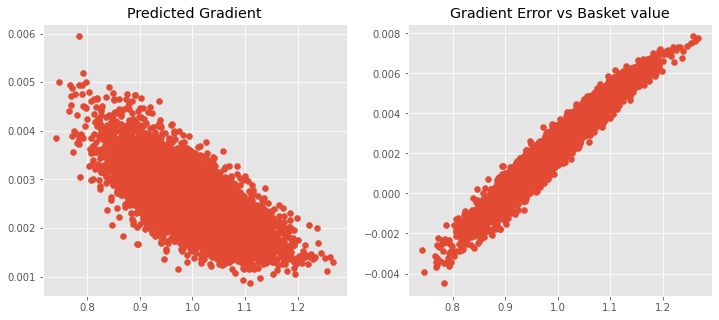

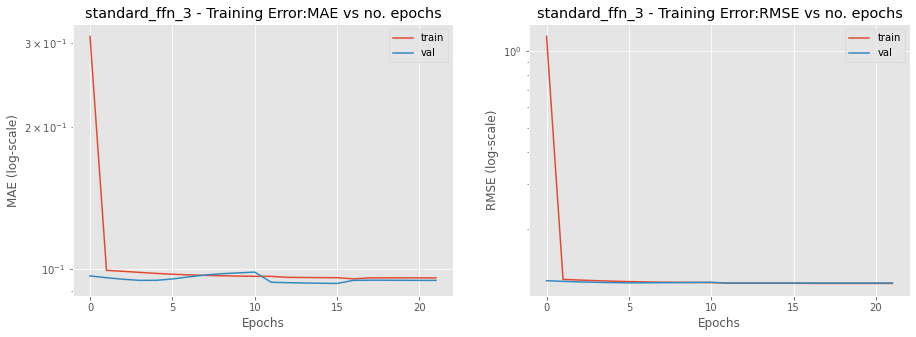

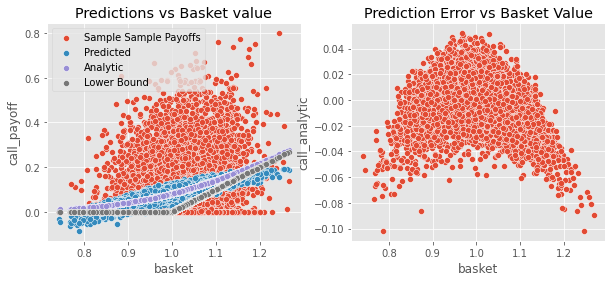

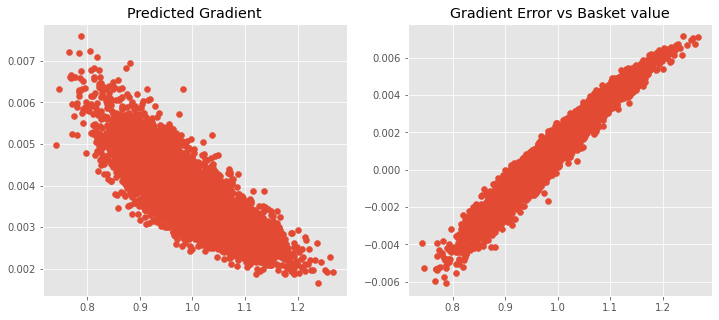

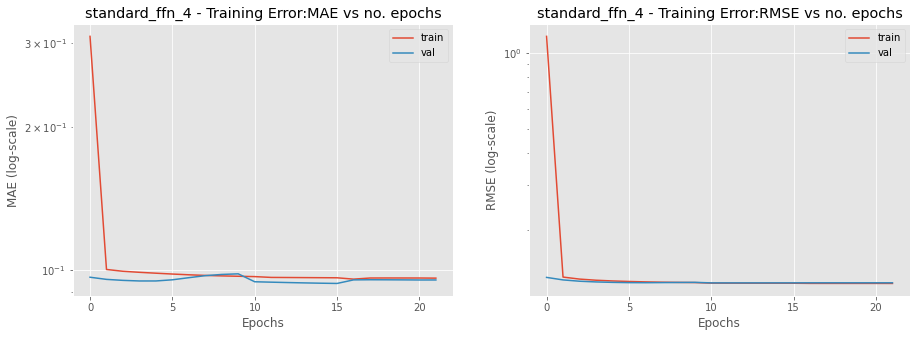

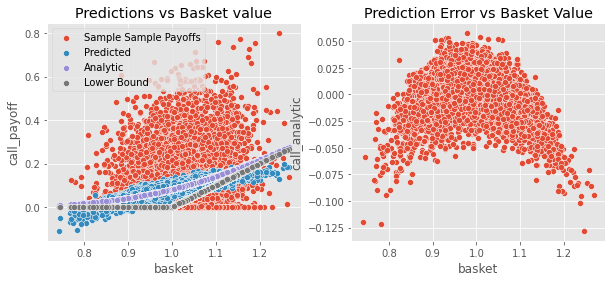

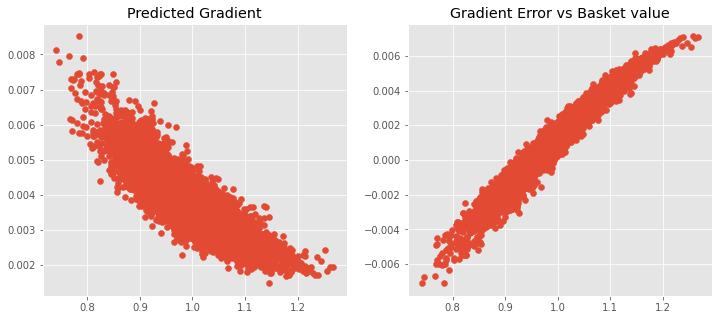

In [5]:
"""
Unconstrained NN
"""
for i in range(5):
    opt = Adam(learning_rate=LR)
    METHOD = "standard_ffn_" + str(i)

    all_models[METHOD] = make_model(
        N_FEATS,
        HIDDEN_UNITS,
        LAYERS,
        DROPOUT_RATIO,
        HIDDEN_ACT,
        OUTPUT_ACT,
        BATCH_NORM,
        SEED=2022 + i,
    )
    all_models[METHOD].compile(optimizer=opt, loss=loss_fn, metrics=METRICS)
    tf.keras.utils.plot_model(
        all_models[METHOD], show_layer_activations=True, show_shapes=True, dpi=72
    )
    """
    Training
    """
    start = time.time()
    history = all_models[METHOD].fit(
        Xs_train,
        ys_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VAL_SPLIT,
        shuffle=False,
        verbose=0,
        callbacks=CALLBACKS,
    )
    train_time = time.time() - start
    metrics = ["MAE", "RMSE"]
    plot_loss(history, metrics, method=METHOD)

    model = all_models[METHOD]

    # with tf.GradientTape() as tape2:
    #     with tf.GradientTape() as model_tape:
    #         output = model(X_tensor)
    #         model_grads = model_tape.gradient(output, X_tensor)
    #     jacobian = tape2.batch_jacobian(model_grads, X_tensor)
    # j_sum = tf.reduce_sum(jacobian, axis=2)
    # hessian_det = tf.linalg.trace(L.T @ jacobian @ L)
    # factor_grad = tf.math.reduce_mean(model_grads, axis = 1).numpy()
    # sns.scatterplot(X_df['basket'], hessian_det)

    start2 = time.time()
    with tf.GradientTape() as model_tape:
        output = model(X_tensor)
        model_grads = model_tape.gradient(output, X_tensor)
    factor_grad = tf.math.reduce_mean(model_grads, axis=1).numpy()
    preds = output.numpy().reshape(-1)
    inference_time = time.time() - start2

    temp = bachelier_eval_wrapper(
        X_df_test,
        X_df_test["call_analytic"].values,
        preds,
        factor_grad,
        lower_bound=np.maximum(X_df_test["basket"].values - 1.0, 0),
        upper_bound=None,
        METHOD=METHOD,
    )
    temp["inference_time"] = inference_time
    temp["train_time"] = train_time
    temp["model_complexity"] = model.count_params()
    all_res += [temp.copy()]

# Differential

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

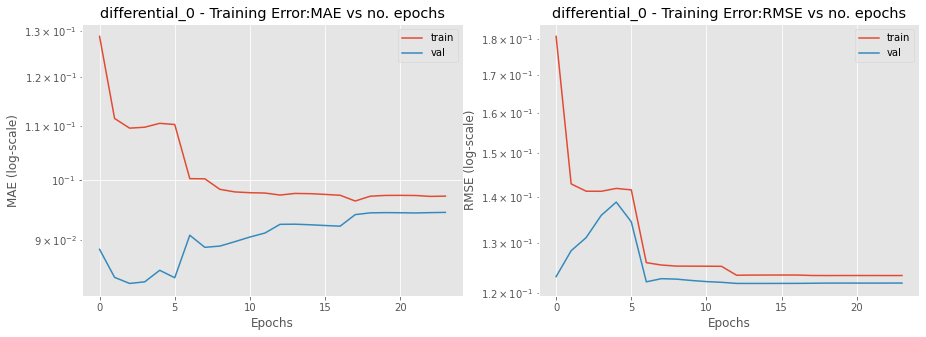

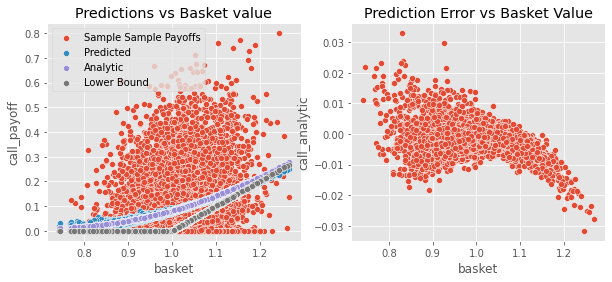

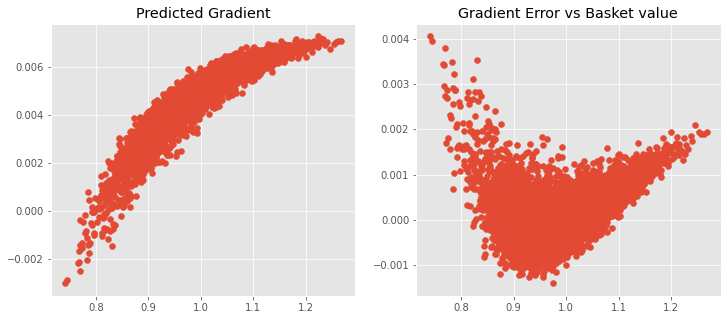

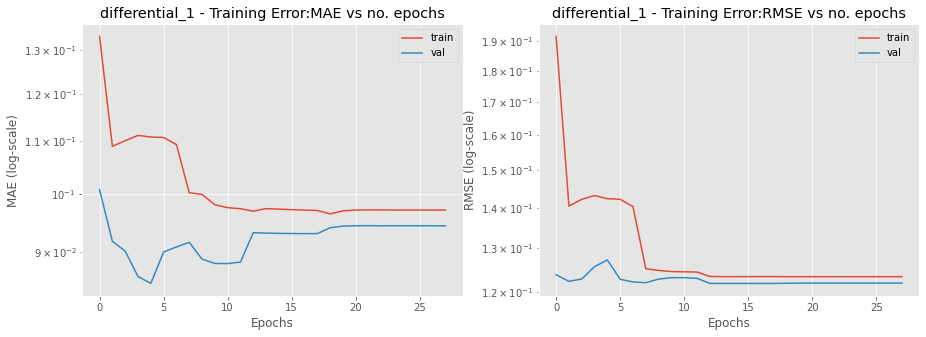

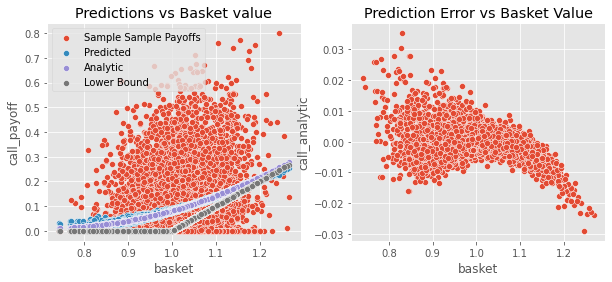

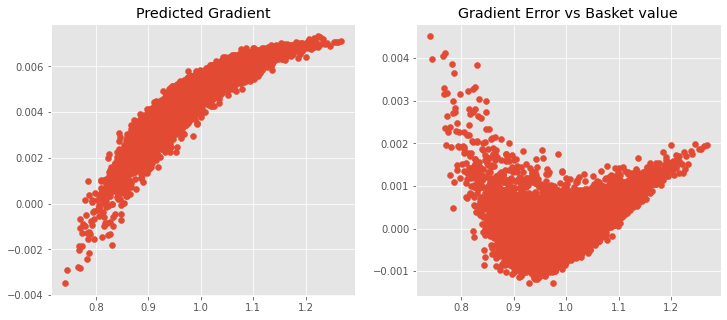

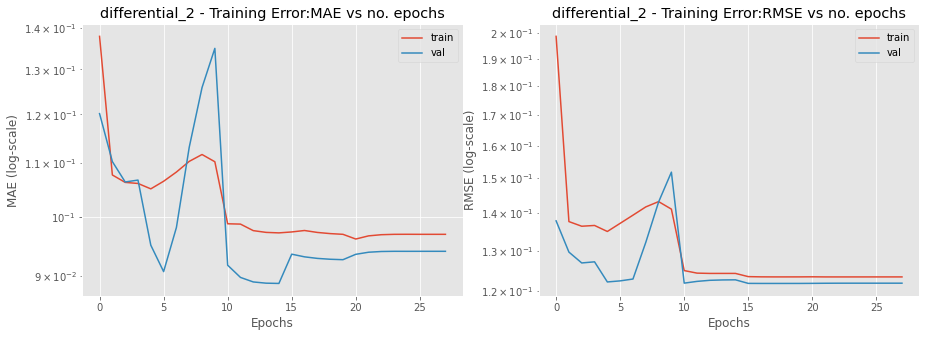

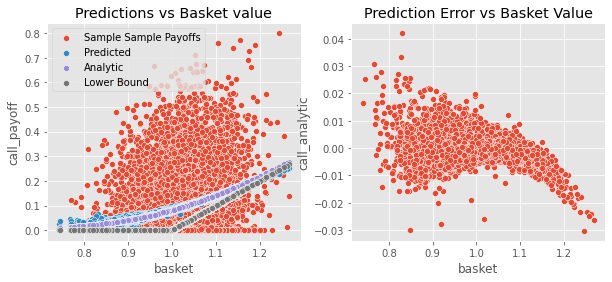

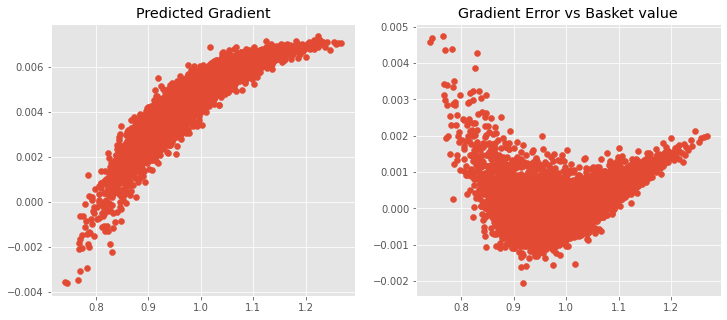

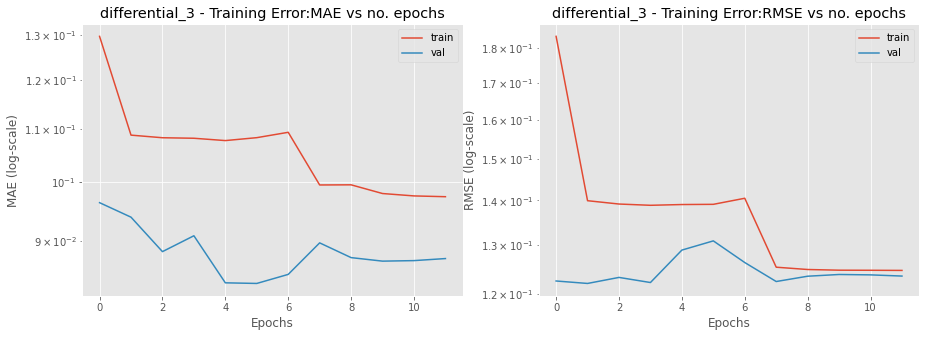

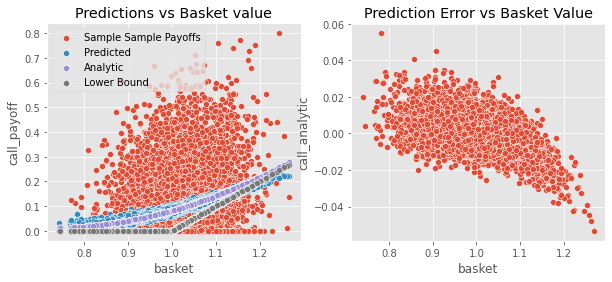

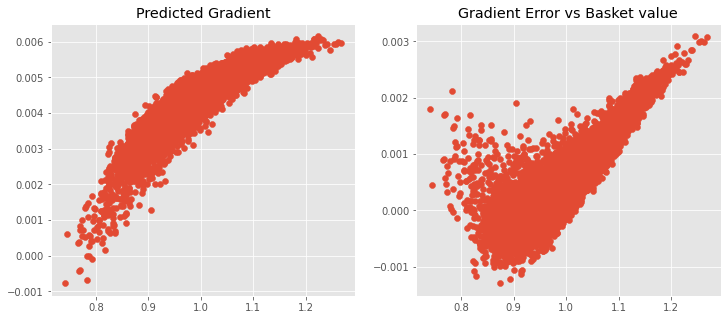

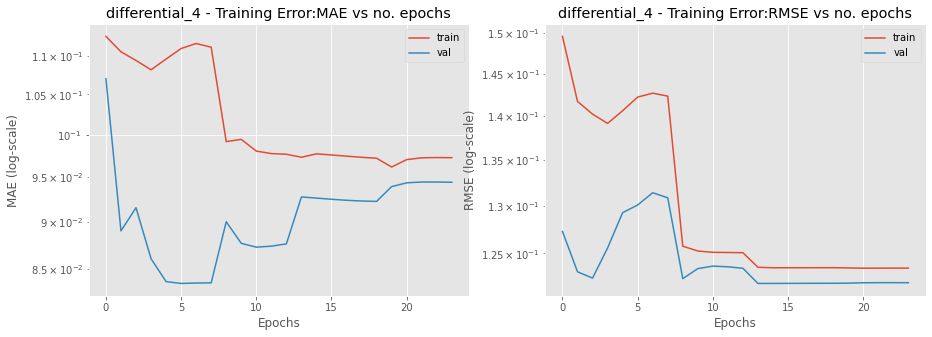

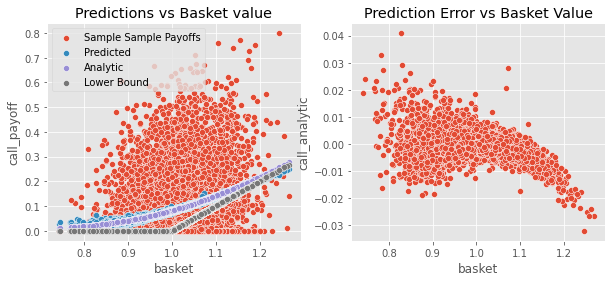

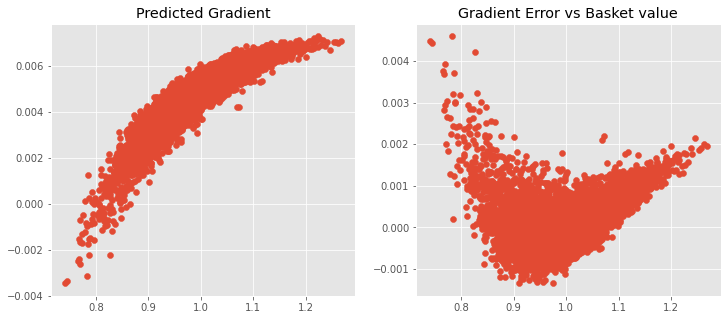

In [6]:
for i in range(5):
    opt = Adam(learning_rate=LR)
    METHOD = "differential_" + str(i)
    model = make_model(
        N_FEATS,
        HIDDEN_UNITS,
        LAYERS,
        DROPOUT_RATIO,
        HIDDEN_ACT,
        OUTPUT_ACT,
        BATCH_NORM,
        SEED=2022 + i,
    )
    all_models[METHOD] = DifferentialModel(model.input, model.outputs)
    all_models[METHOD].compile(optimizer=opt, loss=loss_fn, metrics=METRICS)
    all_models[METHOD].lam = 10 ** 6
    all_models[METHOD].grad_loss = tf.keras.losses.MeanSquaredError()
    start = time.time()
    history = all_models[METHOD].fit(
        Xs_train,
        (ys_train, grads_train),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VAL_SPLIT,
        shuffle=False,
        verbose=0,
        callbacks=CALLBACKS,
    )
    train_time = time.time() - start
    metrics = ["MAE", "RMSE"]
    plot_loss(history, metrics, method=METHOD)

    model = all_models[METHOD]

    # with tf.GradientTape() as tape2:
    #     with tf.GradientTape() as model_tape:
    #         output = model(X_tensor)
    #         model_grads = model_tape.gradient(output, X_tensor)
    #     jacobian = tape2.batch_jacobian(model_grads, X_tensor)
    # j_sum = tf.reduce_sum(jacobian, axis=2)
    # hessian_det = tf.linalg.trace(L.T @ jacobian @ L)
    # factor_grad = tf.math.reduce_mean(model_grads, axis = 1).numpy()
    # sns.scatterplot(X_df['basket'], hessian_det)

    start2 = time.time()
    with tf.GradientTape() as model_tape:
        output = model(X_tensor)
    model_grads = model_tape.gradient(output, X_tensor)
    factor_grad = tf.math.reduce_mean(model_grads, axis=1).numpy()
    preds = output.numpy().reshape(-1)
    inference_time = time.time() - start2

    temp = bachelier_eval_wrapper(
        X_df_test,
        X_df_test["call_analytic"].values,
        preds,
        factor_grad,
        lower_bound=np.maximum(X_df_test["basket"].values - 1.0, 0),
        upper_bound=None,
        METHOD=METHOD,
    )
    temp["inference_time"] = inference_time
    temp["train_time"] = train_time
    temp["model_complexity"] = model.count_params()
    all_res += [temp.copy()]

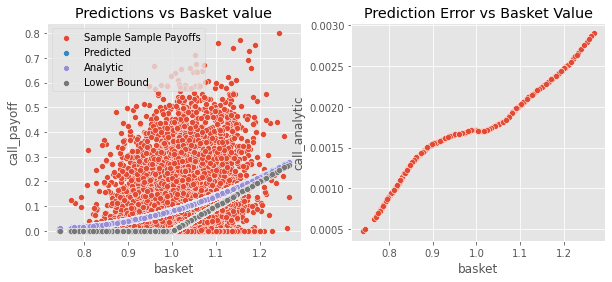

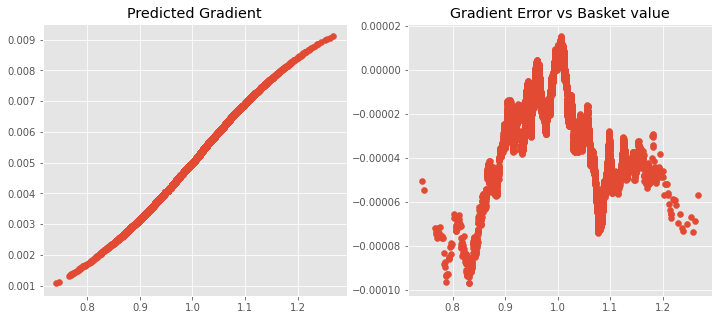

In [7]:
all_res += [
    bachelier_eval_wrapper(
        X_df_test,
        X_df_test["call_analytic_delta"].values,
        X_df_test["call_MC"].values,
        X_df_test["delta_MC"].values,
        lower_bound=np.maximum(X_df_test["basket"] - 1.0, 0),
        upper_bound=None,
        METHOD="MC",
    )
]

In [22]:
res_df = (
    pd.concat(all_res)
    .reset_index()
    .drop_duplicates(subset=["index"])
    .set_index("index")
    .T
)
res_df.loc["inference_time", "MC"] = 136.00
display(res_df.style.background_gradient(axis=1))
print(res_df.style.format("{:.5f}").to_latex())

index,standard_ffn_0,standard_ffn_1,standard_ffn_2,standard_ffn_3,standard_ffn_4,differential_0,differential_1,differential_2,differential_3,differential_4,MC
pred_l1,0.013804,0.013721,0.016262,0.013541,0.014678,0.003389,0.002748,0.002819,0.006766,0.003099,0.001732
pred_l2,0.017977,0.017652,0.020703,0.017566,0.019095,0.004457,0.003924,0.004091,0.008777,0.004309,0.001742
pred_l_inf,0.128825,0.090555,0.099520,0.101782,0.128167,0.032961,0.035283,0.042021,0.054793,0.040869,0.002900
pred_lower_bound_violation,0.037800,0.037200,0.042400,0.039100,0.044700,0.002200,0.001800,0.002100,0.005900,0.002400,0.000000
grad_l1,0.001910,0.001979,0.002622,0.001926,0.002024,0.000407,0.000401,0.000417,0.000666,0.000420,0.000026
grad_l2,0.002335,0.002401,0.003039,0.002350,0.002464,0.000542,0.000540,0.000562,0.000851,0.000561,0.000032
grad_l_inf,0.007745,0.007087,0.007849,0.007142,0.007121,0.004051,0.004512,0.004730,0.003090,0.004597,0.000097
grad_lower_bound_violation,0.000000,0.000000,0.000000,0.000000,0.000000,0.004600,0.005000,0.005800,0.000700,0.005200,0.000000
inference_time,0.096852,0.105667,0.095355,0.094124,0.098045,0.100868,0.096562,0.093906,0.099799,0.109712,136.000000
train_time,9.846058,10.163520,9.930757,8.916696,9.065125,12.381854,14.191432,14.143909,6.619603,12.163350,nan


\begin{tabular}{lrrrrrrrrrrr}
{index} & {standard_ffn_0} & {standard_ffn_1} & {standard_ffn_2} & {standard_ffn_3} & {standard_ffn_4} & {differential_0} & {differential_1} & {differential_2} & {differential_3} & {differential_4} & {MC} \\
pred_l1 & 0.01380 & 0.01372 & 0.01626 & 0.01354 & 0.01468 & 0.00339 & 0.00275 & 0.00282 & 0.00677 & 0.00310 & 0.00173 \\
pred_l2 & 0.01798 & 0.01765 & 0.02070 & 0.01757 & 0.01909 & 0.00446 & 0.00392 & 0.00409 & 0.00878 & 0.00431 & 0.00174 \\
pred_l_inf & 0.12882 & 0.09055 & 0.09952 & 0.10178 & 0.12817 & 0.03296 & 0.03528 & 0.04202 & 0.05479 & 0.04087 & 0.00290 \\
pred_lower_bound_violation & 0.03780 & 0.03720 & 0.04240 & 0.03910 & 0.04470 & 0.00220 & 0.00180 & 0.00210 & 0.00590 & 0.00240 & 0.00000 \\
grad_l1 & 0.00191 & 0.00198 & 0.00262 & 0.00193 & 0.00202 & 0.00041 & 0.00040 & 0.00042 & 0.00067 & 0.00042 & 0.00003 \\
grad_l2 & 0.00233 & 0.00240 & 0.00304 & 0.00235 & 0.00246 & 0.00054 & 0.00054 & 0.00056 & 0.00085 & 0.00056 & 0.00003 \\
grad_l_inf & 0

In [13]:
res_df2 = pd.concat(
    [
        res_df[[f"standard_ffn_{i}" for i in range(5)]].mean(axis=1),
        res_df[[f"differential_{i}" for i in range(5)]].mean(axis=1),
        res_df["MC"],
    ],
    axis=1,
)
res_df2.columns = ["standard_ffn", "differential", "MC"]
display(res_df2.style.background_gradient(axis=1))
print(res_df2.style.format("{:.5f}").to_latex())

,standard_ffn,differential,MC
pred_l1,0.014401,0.003764,0.001732
pred_l2,0.018599,0.005112,0.001742
pred_l_inf,0.109770,0.041185,0.002900
pred_lower_bound_violation,0.040240,0.002880,0.000000
grad_l1,0.002092,0.000462,0.000026
grad_l2,0.002518,0.000611,0.000032
grad_l_inf,0.007389,0.004196,0.000097
grad_lower_bound_violation,0.000000,0.004260,0.000000
inference_time,0.098009,0.100169,136.000000
train_time,9.584431,11.900030,nan


\begin{tabular}{lrrr}
{} & {standard_ffn} & {differential} & {MC} \\
pred_l1 & 0.01440 & 0.00376 & 0.00173 \\
pred_l2 & 0.01860 & 0.00511 & 0.00174 \\
pred_l_inf & 0.10977 & 0.04119 & 0.00290 \\
pred_lower_bound_violation & 0.04024 & 0.00288 & 0.00000 \\
grad_l1 & 0.00209 & 0.00046 & 0.00003 \\
grad_l2 & 0.00252 & 0.00061 & 0.00003 \\
grad_l_inf & 0.00739 & 0.00420 & 0.00010 \\
grad_lower_bound_violation & 0.00000 & 0.00426 & 0.00000 \\
inference_time & 0.09801 & 0.10017 & 136.00000 \\
train_time & 9.58443 & 11.90003 & nan \\
model_complexity & 52225.00000 & 52225.00000 & nan \\
\end{tabular}



Hessian Time 15.939921140670776


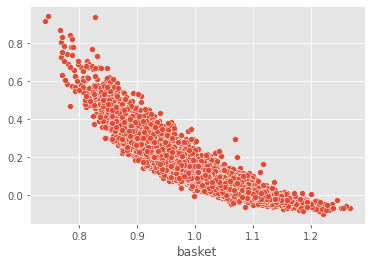

In [21]:
from scipy.linalg import cholesky

SEED = 42
rng = default_rng(SEED)

"""
Define Parameters
"""
N_ASSETS = 100
F = N_ASSETS
N_SAMPLES = 10 ** 4
T = 1.0
K = 1.0

# # Covariance matrix
L = 0.2 * rng.standard_normal((N_ASSETS, F))
cov = L @ L.T
assert np.linalg.det(cov) > 0
L = cholesky(cov)
start = time.time()
with tf.GradientTape() as tape2:
    with tf.GradientTape() as model_tape:
        output = model(X_tensor)
    model_grads = model_tape.gradient(output, X_tensor)
jacobian = tape2.batch_jacobian(model_grads, X_tensor)
j_sum = tf.reduce_sum(jacobian, axis=2)
hessian_det = tf.linalg.trace(L.T @ jacobian @ L)
factor_grad = tf.math.reduce_mean(model_grads, axis=1).numpy()
sns.scatterplot(X_df_test["basket"], hessian_det)
end = time.time()
print("Time to compute Hessian: (s):", end - start)